In [ ]:
#Baseline model
#command line environment update required > conda install -c conda-forge xgboost

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# pandas display behaviour
pd.set_option('display.max_columns', None)

# supress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('RuralCreditData.csv')
df.head()

,Id,city,age,sex,social_class,primary_business,secondary_business,annual_income,monthly_expenses,old_dependents,young_dependents,home_ownership,type_of_house,occupants_count,house_area,sanitary_availability,water_availabity,loan_purpose,loan_tenure,loan_installments,loan_amount
0,1,Dhanbad,22,F,Mochi,Tailoring,Others,36000.0,5000.0,0,2,1.0,R,4,70.0,1.0,0.5,Apparels,12,12,5000.0
1,2,Manjapra,21,F,OBC,Tailoring,none,94000.0,3600.0,1,1,1.0,T1,4,80.0,1.0,0.5,Apparels,12,50,7500.0
2,3,Dhanbad,24,M,Nai,Beauty salon,Others,48000.0,4000.0,0,2,1.0,T1,4,50.0,1.0,0.5,Beauty Salon,12,12,5000.0
3,4,NaN,26,F,OBC,Tailoring,none,7000.0,5000.0,0,2,1.0,T1,5,50.0,1.0,0.5,Apparels,12,50,7500.0
4,5,Nuapada,23,F,OBC,General store,Agriculture,36000.0,3500.0,0,0,1.0,T1,1,112.0,1.0,0.5,Retail Store,12,12,5000.0


In [4]:
print('Shape:', df.shape, f'| Rows: {df.shape[0]}, Columns: {df.shape[1]}')

Shape: (40000, 21) | Rows: 40000, Columns: 21


**Initial Observations:**
1. Monthly_expenses=5000.0 and annual_income=7000.0 Seems like an interesting dataset already.
2. Looking at the values, there is a high possibility that value = value.lower() will reduce the unique values for a feature.

Let's check theory-2:

In [5]:
for feature in list(df.columns):
    unique_count = len(set(df[feature].unique()))
    true_unique_count = len(set([str(x).lower() if isinstance(x, str) else x for x in df[feature].unique()]))

    if unique_count != true_unique_count:
        print(f'Theory-2 proves good for feature - "{feature}", the unique_count is {unique_count}, while true_unique_count is {true_unique_count} only!')

Theory-2 proves good for feature - "city", the unique_count is 857, while true_unique_count is 768 only!
Theory-2 proves good for feature - "social_class", the unique_count is 520, while true_unique_count is 457 only!
Theory-2 proves good for feature - "primary_business", the unique_count is 442, while true_unique_count is 419 only!


Let's update the values to lower to avoid false unique categories in: ["city", "social_class", "primary_business"]

In [6]:
features_to_update = ["city", "social_class", "primary_business"]

In [7]:
for feature in features_to_update:
    df[feature] = df[feature].apply(lambda x: str(x).lower() if isinstance(x, str) else x)

In [8]:
for feature in list(df.columns):
    unique_count = len(set(df[feature].unique()))
    true_unique_count = len(set([str(x).lower() if isinstance(x, str) else x for x in df[feature].unique()]))

    if unique_count != true_unique_count:
        print(f'Theory-2 proves good for feature - "{feature}", the unique_count is {unique_count}, while true_unique_count is {true_unique_count} only!')

print('All good!')

All good!


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     40000 non-null  int64  
 1   city                   38136 non-null  object 
 2   age                    40000 non-null  int64  
 3   sex                    40000 non-null  object 
 4   social_class           34745 non-null  object 
 5   primary_business       39974 non-null  object 
 6   secondary_business     34759 non-null  object 
 7   annual_income          40000 non-null  float64
 8   monthly_expenses       39880 non-null  float64
 9   old_dependents         40000 non-null  int64  
 10  young_dependents       40000 non-null  int64  
 11  home_ownership         39621 non-null  float64
 12  type_of_house          39306 non-null  object 
 13  occupants_count        40000 non-null  int64  
 14  house_area             40000 non-null  float64
 15  sa

dtype assignment looks good!

In [10]:
df.duplicated().sum()

0

There are no duplicates!

In [11]:
df.isnull().sum()

Id                          0
city                     1864
age                         0
sex                         0
social_class             5255
primary_business           26
secondary_business       5241
annual_income               0
monthly_expenses          120
old_dependents              0
young_dependents            0
home_ownership            379
type_of_house             694
occupants_count             0
house_area                  0
sanitary_availability     208
water_availabity         5253
loan_purpose               26
loan_tenure                 0
loan_installments           0
loan_amount                 0
dtype: int64

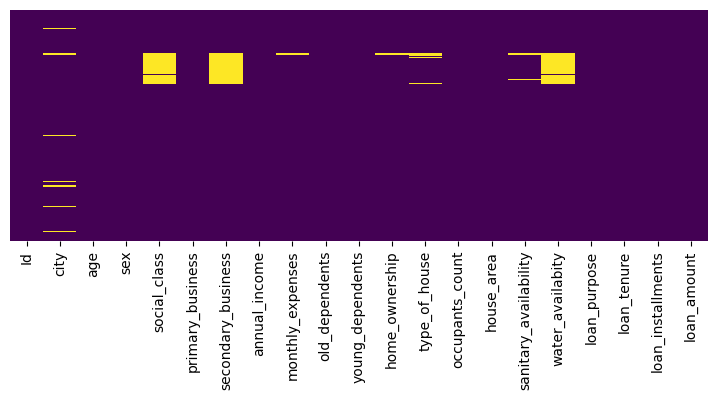

In [12]:
plt.figure(figsize=(9,3))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis');

There are missing values. 'll manage this.

In [13]:
df.nunique()

Id                       40000
city                       767
age                         62
sex                          3
social_class               456
primary_business           418
secondary_business           5
annual_income              359
monthly_expenses           260
old_dependents               4
young_dependents             8
home_ownership               2
type_of_house                3
occupants_count             23
house_area                 391
sanitary_availability        3
water_availabity             4
loan_purpose                37
loan_tenure                 11
loan_installments           21
loan_amount                115
dtype: int64

#### Personal Details:

In [14]:
personal_features = ["city","age","sex","social_class"]

In [15]:
personal_data = pd.DataFrame(df,columns=personal_features)
personal_data.head()

,city,age,sex,social_class
0,dhanbad,22,F,mochi
1,manjapra,21,F,obc
2,dhanbad,24,M,nai
3,NaN,26,F,obc
4,nuapada,23,F,obc


In [16]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   city          38136 non-null  object
 1   age           40000 non-null  int64 
 2   sex           40000 non-null  object
 3   social_class  34745 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [17]:
personal_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,40000.0,55.1599,3830.35566,2.0,29.0,35.0,42.0,766105.0


In [18]:
personal_data.isnull().sum()

city            1864
age                0
sex                0
social_class    5255
dtype: int64

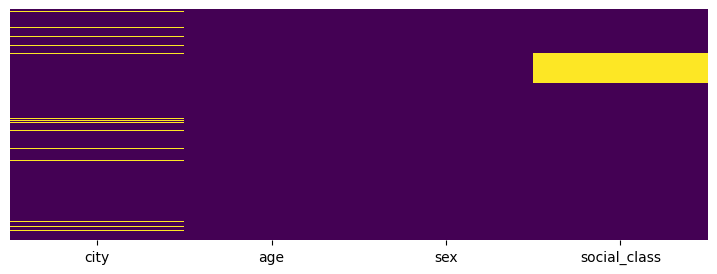

In [19]:
plt.figure(figsize=(9,3))
sns.heatmap(personal_data.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [20]:
personal_data.nunique()

city            767
age              62
sex               3
social_class    456
dtype: int64

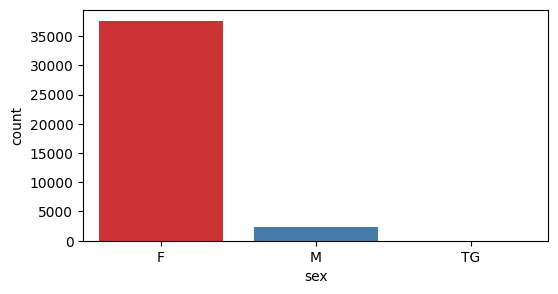

In [21]:
plt.figure(figsize=(6,3))
sns.countplot(data=personal_data, x='sex', palette='Set1');

In [22]:
personal_data[(personal_data['sex']=="M")].count()

city            2193
age             2371
sex             2371
social_class    2278
dtype: int64

In [23]:
personal_data[(personal_data['sex']=="F")].count()

city            35938
age             37622
sex             37622
social_class    32460
dtype: int64

In [24]:
personal_data[(personal_data['sex']=="TG")].count()

city            5
age             7
sex             7
social_class    7
dtype: int64

#### Financial details:

In [25]:
financial_features = ["primary_business", "secondary_business", "annual_income", "monthly_expenses", "old_dependents", "young_dependents"]

In [26]:
financial_data = pd.DataFrame(df, columns=financial_features)
financial_data.head()

,primary_business,secondary_business,annual_income,monthly_expenses,old_dependents,young_dependents
0,tailoring,Others,36000.0,5000.0,0,2
1,tailoring,none,94000.0,3600.0,1,1
2,beauty salon,Others,48000.0,4000.0,0,2
3,tailoring,none,7000.0,5000.0,0,2
4,general store,Agriculture,36000.0,3500.0,0,0


In [27]:
financial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   primary_business    39974 non-null  object 
 1   secondary_business  34759 non-null  object 
 2   annual_income       40000 non-null  float64
 3   monthly_expenses    39880 non-null  float64
 4   old_dependents      40000 non-null  int64  
 5   young_dependents    40000 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 1.8+ MB


In [28]:
financial_data.describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,40000.0,37640.214425,28739.116481,0.0,14400.0,36000.0,56000.0,1200000.0
monthly_expenses,39880.0,3810.875401,4592.958009,2.0,2500.0,3500.0,4000.0,240000.0
old_dependents,40000.0,0.044900,0.222003,0.0,0.0,0.0,0.0,3.0
young_dependents,40000.0,1.137100,1.073840,0.0,0.0,1.0,2.0,7.0


In [29]:
financial_data.isnull().sum()

primary_business        26
secondary_business    5241
annual_income            0
monthly_expenses       120
old_dependents           0
young_dependents         0
dtype: int64

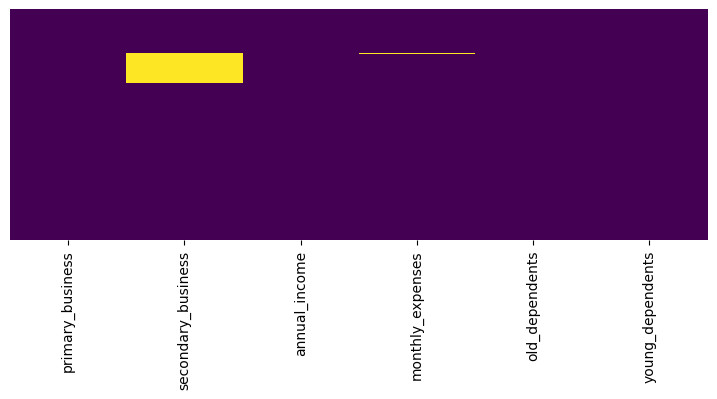

In [30]:
plt.figure(figsize=(9,3))
sns.heatmap(financial_data.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [31]:
financial_data.nunique()

primary_business      418
secondary_business      5
annual_income         359
monthly_expenses      260
old_dependents          4
young_dependents        8
dtype: int64

Count of different categories in - ["secondary_business, old_dependents, and young_dependents"]: 



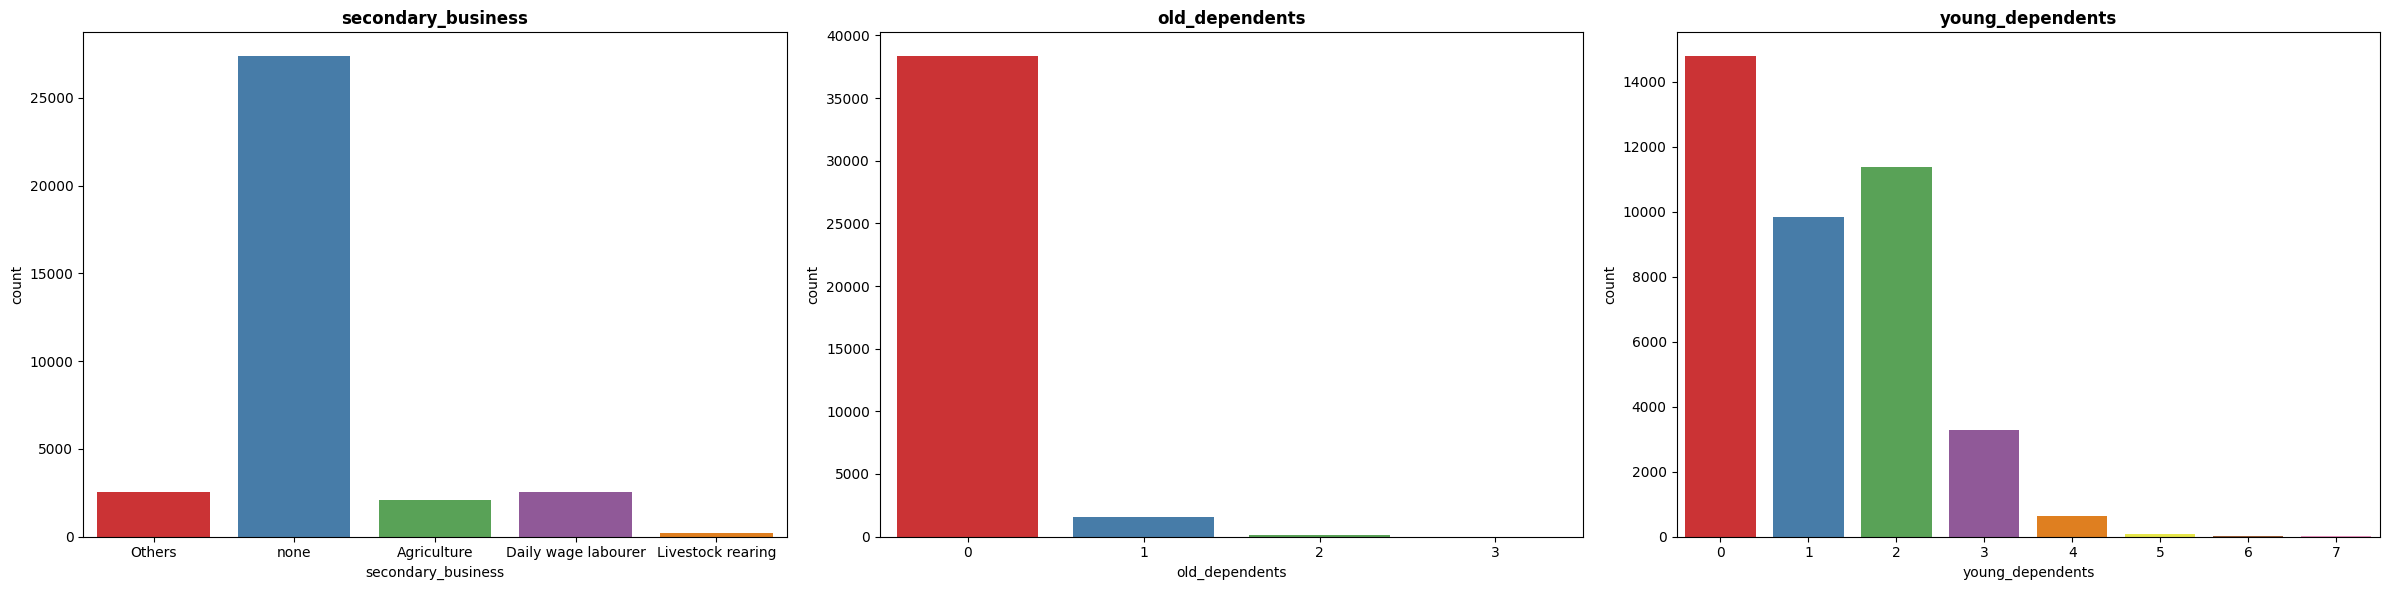

In [32]:
print('Count of different categories in - ["secondary_business, old_dependents, and young_dependents"]: \n')
fig, axis = plt.subplots(1,3, figsize=(24,6))

all_cols = ["secondary_business", "old_dependents", "young_dependents"]
for i, ax in enumerate(axis.flatten()):
    if i < len(all_cols):
        sns.countplot(data=financial_data, x=all_cols[i], ax=ax, palette='Set1')
        ax.set_title(all_cols[i], fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

#### House details:

In [33]:
house_features = ["home_ownership", "type_of_house", "occupants_count", "house_area", "sanitary_availability", "water_availabity"]

In [34]:
house_data = pd.DataFrame(df, columns=house_features)
house_data.head()

,home_ownership,type_of_house,occupants_count,house_area,sanitary_availability,water_availabity
0,1.0,R,4,70.0,1.0,0.5
1,1.0,T1,4,80.0,1.0,0.5
2,1.0,T1,4,50.0,1.0,0.5
3,1.0,T1,5,50.0,1.0,0.5
4,1.0,T1,1,112.0,1.0,0.5


In [35]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   home_ownership         39621 non-null  float64
 1   type_of_house          39306 non-null  object 
 2   occupants_count        40000 non-null  int64  
 3   house_area             40000 non-null  float64
 4   sanitary_availability  39792 non-null  float64
 5   water_availabity       34747 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.8+ MB


In [36]:
house_data.describe().T

,count,mean,std,min,25%,50%,75%,max
home_ownership,39621.0,0.972489,0.163568,0.0,1.0,1.0,1.0,1.0
occupants_count,40000.0,26.641000,4749.995485,0.0,2.0,3.0,4.0,950000.0
house_area,40000.0,552.804750,4596.921905,0.0,200.0,400.0,600.0,700000.0
sanitary_availability,39792.0,0.686369,0.464028,-1.0,0.0,1.0,1.0,1.0
water_availabity,34747.0,0.753216,0.255337,-1.0,0.5,1.0,1.0,1.0


In [37]:
house_data.isnull().sum()

home_ownership            379
type_of_house             694
occupants_count             0
house_area                  0
sanitary_availability     208
water_availabity         5253
dtype: int64

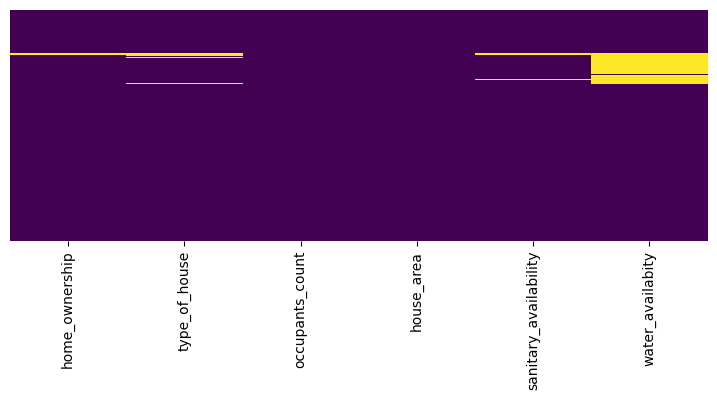

In [38]:
plt.figure(figsize=(9,3))
sns.heatmap(house_data.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [39]:
house_data.count()

home_ownership           39621
type_of_house            39306
occupants_count          40000
house_area               40000
sanitary_availability    39792
water_availabity         34747
dtype: int64

In [40]:
house_data.nunique()

home_ownership             2
type_of_house              3
occupants_count           23
house_area               391
sanitary_availability      3
water_availabity           4
dtype: int64

Count of different categories in - ["home_ownership", "type_of_house", "sanitary_availability", "water_availabity"]: 



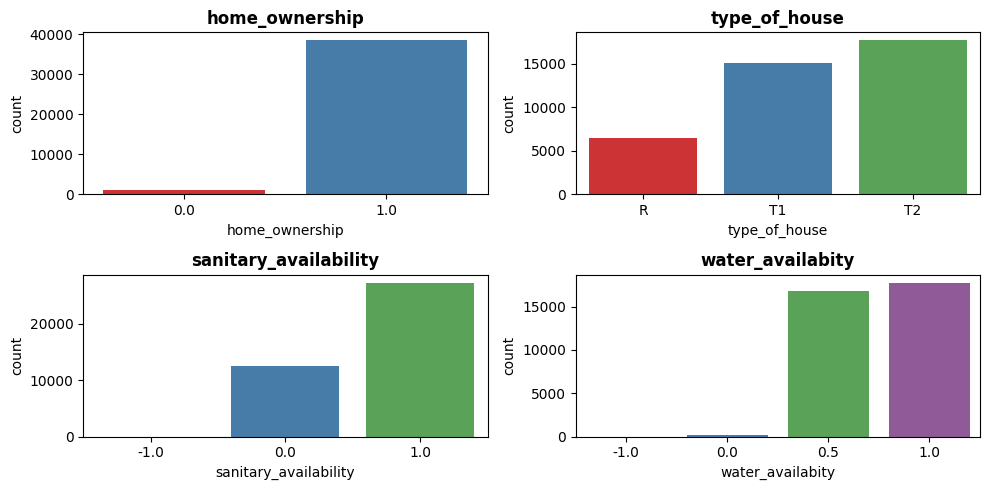

In [41]:
print('Count of different categories in - ["home_ownership", "type_of_house", "sanitary_availability", "water_availabity"]: \n')
fig, axis = plt.subplots(2,2, figsize=(10,5))

all_cols = ["home_ownership", "type_of_house", "sanitary_availability", "water_availabity"]
for i, ax in enumerate(axis.flatten()):
    if i < len(all_cols):
        sns.countplot(data=house_data, x=all_cols[i], ax=ax, palette='Set1')
        ax.set_title(all_cols[i], fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

#### Loan details:

In [42]:
loan_features = ["loan_purpose","loan_tenure","loan_installments","loan_amount"]

In [43]:
loan_data = pd.DataFrame(df, columns=loan_features)
loan_data.head()

,loan_purpose,loan_tenure,loan_installments,loan_amount
0,Apparels,12,12,5000.0
1,Apparels,12,50,7500.0
2,Beauty Salon,12,12,5000.0
3,Apparels,12,50,7500.0
4,Retail Store,12,12,5000.0


In [44]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loan_purpose       39974 non-null  object 
 1   loan_tenure        40000 non-null  int64  
 2   loan_installments  40000 non-null  int64  
 3   loan_amount        40000 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.2+ MB


In [45]:
loan_data.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_tenure,40000.0,12.032225,1.367473,3.0,12.0,12.0,12.0,84.0
loan_installments,40000.0,21.761175,16.682458,0.0,12.0,12.0,50.0,84.0
loan_amount,40000.0,8412.592500,13596.938096,100.0,5000.0,8000.0,10000.0,1343000.0


In [46]:
loan_data.isnull().sum()

loan_purpose         26
loan_tenure           0
loan_installments     0
loan_amount           0
dtype: int64

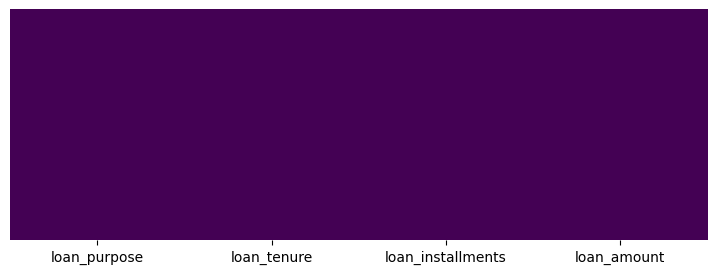

In [47]:
plt.figure(figsize=(9,3))
sns.heatmap(loan_data.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [48]:
loan_data.count()

loan_purpose         39974
loan_tenure          40000
loan_installments    40000
loan_amount          40000
dtype: int64

In [49]:
loan_data.nunique()

loan_purpose          37
loan_tenure           11
loan_installments     21
loan_amount          115
dtype: int64

#### Handling missing values:

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     40000 non-null  int64  
 1   city                   38136 non-null  object 
 2   age                    40000 non-null  int64  
 3   sex                    40000 non-null  object 
 4   social_class           34745 non-null  object 
 5   primary_business       39974 non-null  object 
 6   secondary_business     34759 non-null  object 
 7   annual_income          40000 non-null  float64
 8   monthly_expenses       39880 non-null  float64
 9   old_dependents         40000 non-null  int64  
 10  young_dependents       40000 non-null  int64  
 11  home_ownership         39621 non-null  float64
 12  type_of_house          39306 non-null  object 
 13  occupants_count        40000 non-null  int64  
 14  house_area             40000 non-null  float64
 15  sa

In [51]:
df.isnull().sum()

Id                          0
city                     1864
age                         0
sex                         0
social_class             5255
primary_business           26
secondary_business       5241
annual_income               0
monthly_expenses          120
old_dependents              0
young_dependents            0
home_ownership            379
type_of_house             694
occupants_count             0
house_area                  0
sanitary_availability     208
water_availabity         5253
loan_purpose               26
loan_tenure                 0
loan_installments           0
loan_amount                 0
dtype: int64

In [52]:
def perecnt_missing(df):
    missing = {}
    for feature in list(df.columns):
        missing[feature] = round(100*df[feature].isnull().sum()/len(df), 2)
    return json.dumps(missing, indent=4)

In [53]:
 print('% of missing data in each feature: \n', perecnt_missing(df))

% of missing data in each feature: 
 {
    "Id": 0.0,
    "city": 4.66,
    "age": 0.0,
    "sex": 0.0,
    "social_class": 13.14,
    "primary_business": 0.06,
    "secondary_business": 13.1,
    "annual_income": 0.0,
    "monthly_expenses": 0.3,
    "old_dependents": 0.0,
    "young_dependents": 0.0,
    "home_ownership": 0.95,
    "type_of_house": 1.74,
    "occupants_count": 0.0,
    "house_area": 0.0,
    "sanitary_availability": 0.52,
    "water_availabity": 13.13,
    "loan_purpose": 0.06,
    "loan_tenure": 0.0,
    "loan_installments": 0.0,
    "loan_amount": 0.0
}


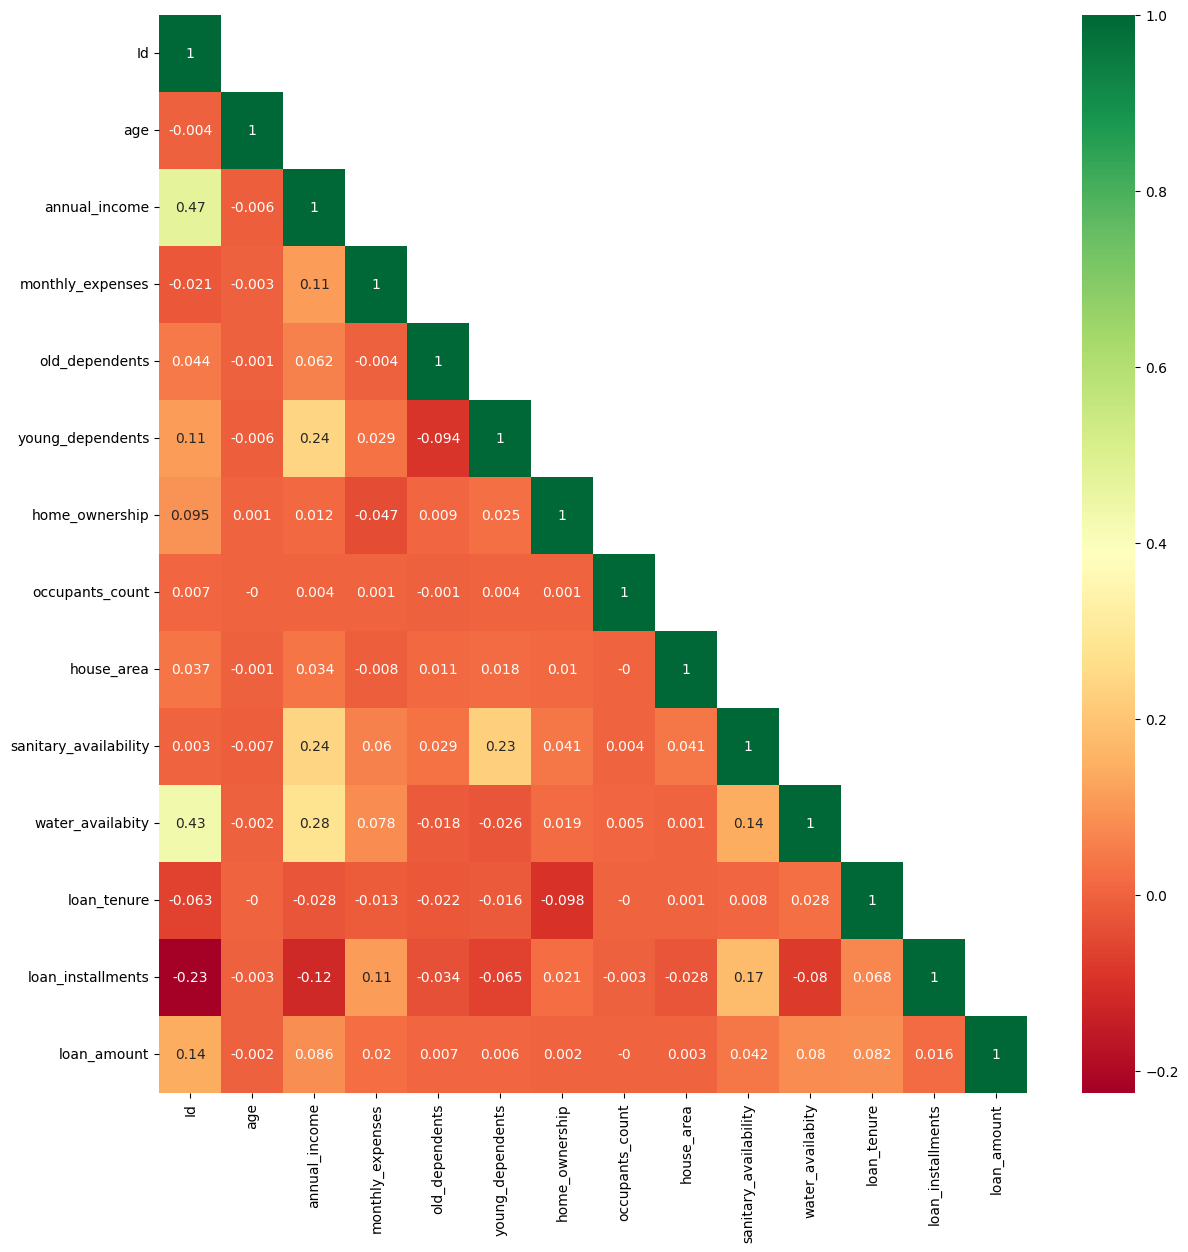

In [54]:
plt.figure(figsize=(14,14))

corr_matrix = df.corr(numeric_only=True)
mask = np.tril(np.ones_like(corr_matrix, dtype=bool))
lower_triangle = corr_matrix.where(mask)

sns.heatmap(round(lower_triangle, 3), annot=True, cmap='RdYlGn');

No strong corelation!

In [55]:
all_features = list(df.columns)
print('>>> All features: \n', all_features)

>>> All features: 
 ['Id', 'city', 'age', 'sex', 'social_class', 'primary_business', 'secondary_business', 'annual_income', 'monthly_expenses', 'old_dependents', 'young_dependents', 'home_ownership', 'type_of_house', 'occupants_count', 'house_area', 'sanitary_availability', 'water_availabity', 'loan_purpose', 'loan_tenure', 'loan_installments', 'loan_amount']


In [56]:
dependent_feature = ['loan_amount']
independent_features = [feature for feature in all_features if feature not in dependent_feature]

print('>>> All independent_features: \n', independent_features)

>>> All independent_features: 
 ['Id', 'city', 'age', 'sex', 'social_class', 'primary_business', 'secondary_business', 'annual_income', 'monthly_expenses', 'old_dependents', 'young_dependents', 'home_ownership', 'type_of_house', 'occupants_count', 'house_area', 'sanitary_availability', 'water_availabity', 'loan_purpose', 'loan_tenure', 'loan_installments']


In [57]:
# Check unique categories in features with less than or equal to 10 unique values
for feature in all_features:
    if len(df[feature].unique()) <= 10:
        print(f'>> Unique categories in {feature}: \n', df[feature].unique(), '\n')

>> Unique categories in sex: 
 ['F' 'M' 'TG'] 

>> Unique categories in secondary_business: 
 ['Others' 'none' 'Agriculture' 'Daily wage labourer' 'Livestock rearing'
 nan] 

>> Unique categories in old_dependents: 
 [0 1 2 3] 

>> Unique categories in young_dependents: 
 [2 1 0 3 4 5 6 7] 

>> Unique categories in home_ownership: 
 [ 1.  0. nan] 

>> Unique categories in type_of_house: 
 ['R' 'T1' 'T2' nan] 

>> Unique categories in sanitary_availability: 
 [ 1. nan  0. -1.] 

>> Unique categories in water_availabity: 
 [ 0.5  nan  1.   0.  -1. ] 



In [58]:
cat_features = [feature for feature in independent_features if df[feature].dtype == 'O'] + ['home_ownership', 'sanitary_availability', 'water_availabity']
num_features = [feature for feature in independent_features if feature not in cat_features + ['Id']]

In [59]:
len(df.columns), (len(cat_features) + len(num_features)) # +1 for Id

(21, 19)

In [60]:
print('>>> All Categorical features: \n', cat_features)
print('\n>>> All Numerical features: \n', num_features)

>>> All Categorical features: 
 ['city', 'sex', 'social_class', 'primary_business', 'secondary_business', 'type_of_house', 'loan_purpose', 'home_ownership', 'sanitary_availability', 'water_availabity']

>>> All Numerical features: 
 ['age', 'annual_income', 'monthly_expenses', 'old_dependents', 'young_dependents', 'occupants_count', 'house_area', 'loan_tenure', 'loan_installments']


In [61]:
print(perecnt_missing(df[cat_features]))

{
    "city": 4.66,
    "sex": 0.0,
    "social_class": 13.14,
    "primary_business": 0.06,
    "secondary_business": 13.1,
    "type_of_house": 1.74,
    "loan_purpose": 0.06,
    "home_ownership": 0.95,
    "sanitary_availability": 0.52,
    "water_availabity": 13.13
}


In [62]:
print(perecnt_missing(df[num_features]))

{
    "age": 0.0,
    "annual_income": 0.0,
    "monthly_expenses": 0.3,
    "old_dependents": 0.0,
    "young_dependents": 0.0,
    "occupants_count": 0.0,
    "house_area": 0.0,
    "loan_tenure": 0.0,
    "loan_installments": 0.0
}


Not much data is missing, let's not drop any features, instead let's impute missing values with mode/median:

In [63]:
for feature in independent_features:
    if df[feature].isnull().sum() > 0:
        if feature in cat_features:
            print('Mode imputation applied for:', feature)
            df[feature] = df[feature].fillna(df[feature].mode()[0]) # Mode imputation for cat_features
        else:
            print('Mean imputation applied for:', feature)
            df[feature] = df[feature].fillna(df[feature].mean()) # Mean imputation for num_feature

Mode imputation applied for: city
Mode imputation applied for: social_class
Mode imputation applied for: primary_business
Mode imputation applied for: secondary_business
Mean imputation applied for: monthly_expenses
Mode imputation applied for: home_ownership
Mode imputation applied for: type_of_house
Mode imputation applied for: sanitary_availability
Mode imputation applied for: water_availabity
Mode imputation applied for: loan_purpose


In [64]:
print(perecnt_missing(df))

{
    "Id": 0.0,
    "city": 0.0,
    "age": 0.0,
    "sex": 0.0,
    "social_class": 0.0,
    "primary_business": 0.0,
    "secondary_business": 0.0,
    "annual_income": 0.0,
    "monthly_expenses": 0.0,
    "old_dependents": 0.0,
    "young_dependents": 0.0,
    "home_ownership": 0.0,
    "type_of_house": 0.0,
    "occupants_count": 0.0,
    "house_area": 0.0,
    "sanitary_availability": 0.0,
    "water_availabity": 0.0,
    "loan_purpose": 0.0,
    "loan_tenure": 0.0,
    "loan_installments": 0.0,
    "loan_amount": 0.0
}


All good now!

In [65]:
df.head()

,Id,city,age,sex,social_class,primary_business,secondary_business,annual_income,monthly_expenses,old_dependents,young_dependents,home_ownership,type_of_house,occupants_count,house_area,sanitary_availability,water_availabity,loan_purpose,loan_tenure,loan_installments,loan_amount
0,1,dhanbad,22,F,mochi,tailoring,Others,36000.0,5000.0,0,2,1.0,R,4,70.0,1.0,0.5,Apparels,12,12,5000.0
1,2,manjapra,21,F,obc,tailoring,none,94000.0,3600.0,1,1,1.0,T1,4,80.0,1.0,0.5,Apparels,12,50,7500.0
2,3,dhanbad,24,M,nai,beauty salon,Others,48000.0,4000.0,0,2,1.0,T1,4,50.0,1.0,0.5,Beauty Salon,12,12,5000.0
3,4,pusad,26,F,obc,tailoring,none,7000.0,5000.0,0,2,1.0,T1,5,50.0,1.0,0.5,Apparels,12,50,7500.0
4,5,nuapada,23,F,obc,general store,Agriculture,36000.0,3500.0,0,0,1.0,T1,1,112.0,1.0,0.5,Retail Store,12,12,5000.0


In [66]:
# Check Age range

df_age = df.copy()

# Create bins for age groups
bins = [0, 17, 81, float('inf')]
labels = ['<18', '18-80', '>80']

# Categorize ages into age groups
df_age['age_group'] = pd.cut(df_age['age'], bins=bins, labels=labels)

# Get count of each age group
age_group_counts = df_age['age_group'].value_counts()

print(age_group_counts)

age_group
18-80    39993
>80          5
<18          2
Name: count, dtype: int64


**Let's drop age<18 and age>80 line items:**

In [67]:
df = df.drop(df[(df['age'] < 18) | (df['age'] > 80)].index)

#### Vusualizations:

##### Categorical features:

In [68]:
len(cat_features)

10

In [69]:
def get_central_loan_amt(df, cat_columns, centrality):
    central_loan_amt_combined = {}

    for col in cat_columns:
        central_loan_amts = {}

        types = list(df[col].unique())
        for a_type in types:
            if centrality == 'mean':
                central_loan_amt = df[df[col] == a_type]['loan_amount'].mean()
                central_loan_amts[a_type] = central_loan_amt
            elif centrality == 'median':
                central_loan_amt = df[df[col] == a_type]['loan_amount'].median()
                central_loan_amts[a_type] = central_loan_amt
        sorted_items = sorted(central_loan_amts.items())
        central_loan_amts = dict(sorted_items)

        central_loan_amt_combined[col] = central_loan_amts

    return central_loan_amt_combined

In [70]:
mean_loan_amts = get_central_loan_amt(df, cat_features, centrality='mean')

In [71]:
median_loan_amts = get_central_loan_amt(df, cat_features, centrality='median')

Variation of "mean" loan_amount across each category in a categorical feature: 

	 For city - Max Value: 1000000.0 | Min Value: 2000.0 | Difference = 998000.0
	 For sex - Max Value: 9001.0 | Min Value: 8376.0 | Difference = 625.0
	 For social_class - Max Value: 1343000.0 | Min Value: 3000.0 | Difference = 1340000.0
	 For primary_business - Max Value: 750000.0 | Min Value: 2500.0 | Difference = 747500.0
	 For secondary_business - Max Value: 8677.0 | Min Value: 6257.0 | Difference = 2420.0
	 For type_of_house - Max Value: 9533.0 | Min Value: 8183.0 | Difference = 1350.0
	 For loan_purpose - Max Value: 292400.0 | Min Value: 2500.0 | Difference = 289900.0
	 For home_ownership - Max Value: 8417.0 | Min Value: 8282.0 | Difference = 135.0
	 For sanitary_availability - Max Value: 8793.0 | Min Value: 7574.0 | Difference = 1219.0
	 For water_availabity - Max Value: 9148.0 | Min Value: 7648.0 | Difference = 1500.0


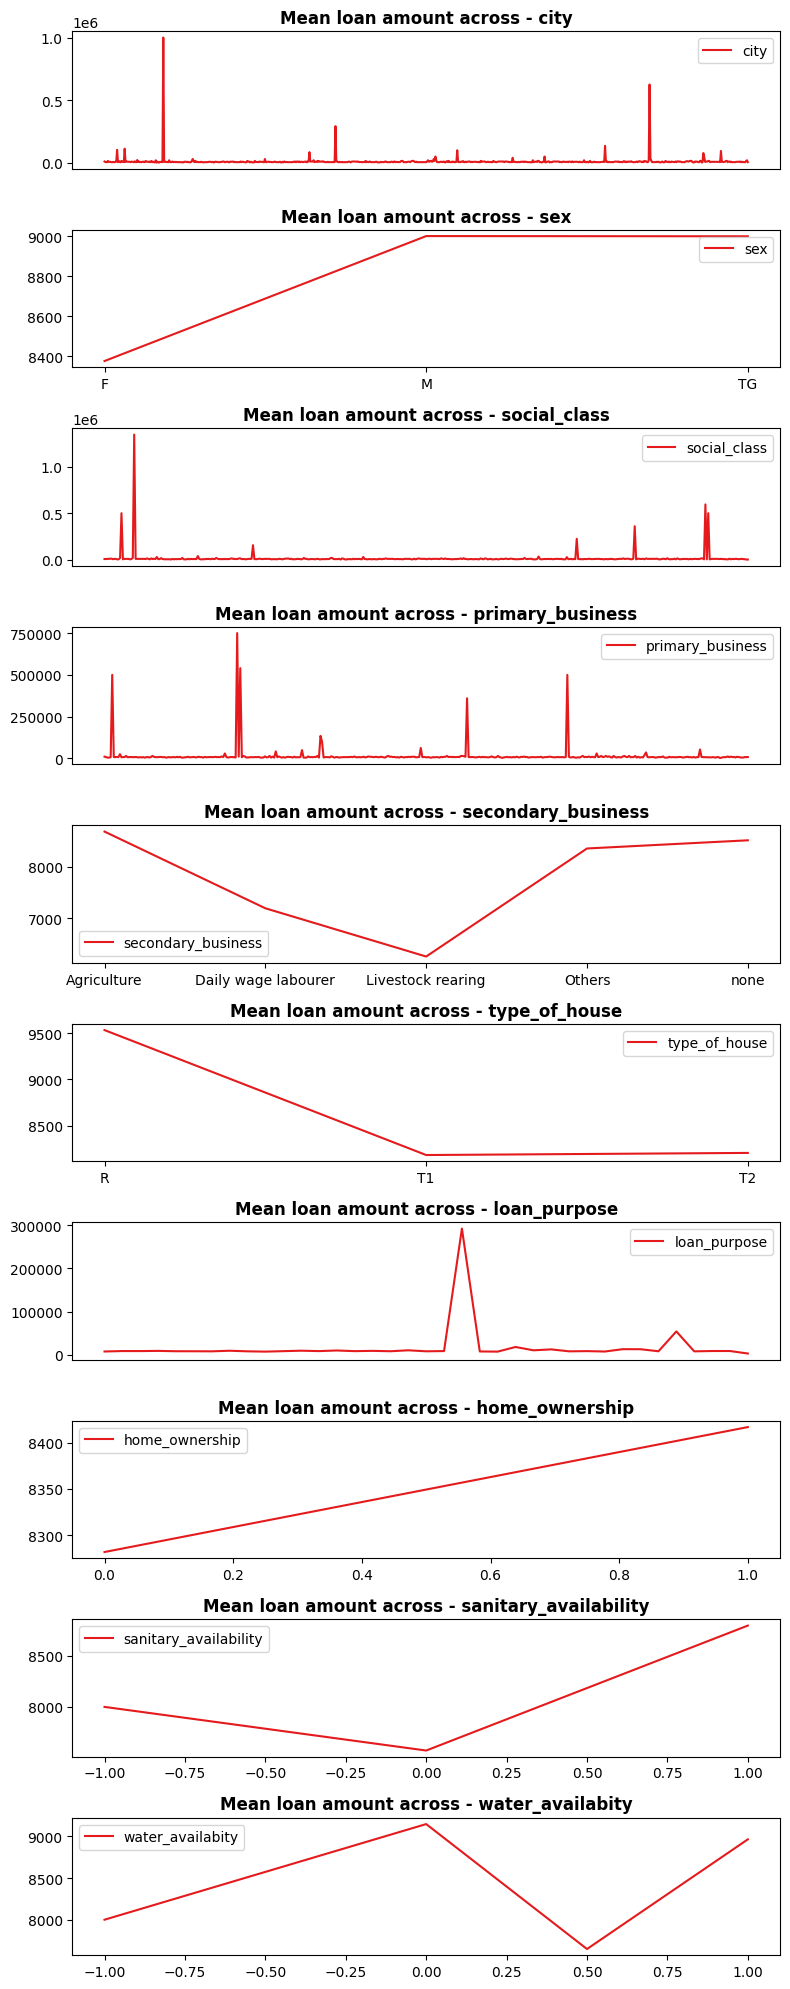

In [72]:
print('Variation of "mean" loan_amount across each category in a categorical feature: \n')
fig, axis = plt.subplots(10,1, figsize=(8,20))

all_cols = list(mean_loan_amts.keys())
for i, ax in enumerate(axis.flatten()):
    if i < len(mean_loan_amts.keys()):
        mean_price_df = pd.DataFrame.from_dict(mean_loan_amts[all_cols[i]], orient='index', columns=[all_cols[i]])
        sns.lineplot(data=mean_price_df, ax=ax, palette='Set1')
        ax.set_title('Mean loan amount across - ' + all_cols[i], fontsize=12, fontweight='bold')

        # Check number of xticks
        if len(mean_price_df.index) > 10:
            ax.set_xticks([])  # Remove xticks if count of all xticks>10

        max_value, min_value = round(max(mean_price_df[all_cols[i]]), 0), round(min(mean_price_df[all_cols[i]]), 0)
        diff = max_value - min_value
        print(f"\t For {all_cols[i]} - Max Value: {max_value} | Min Value: {min_value} | Difference = {diff}")
plt.tight_layout()
plt.show()

Variation of "median" loan_amount across each category in a categorical feature: 

	 For city - Max Value: 1000000.0 | Min Value: 2000.0 | Difference = 998000.0
	 For sex - Max Value: 10000.0 | Min Value: 8000.0 | Difference = 2000.0
	 For social_class - Max Value: 1343000.0 | Min Value: 3000.0 | Difference = 1340000.0
	 For primary_business - Max Value: 750000.0 | Min Value: 2500.0 | Difference = 747500.0
	 For secondary_business - Max Value: 8000.0 | Min Value: 5000.0 | Difference = 3000.0
	 For type_of_house - Max Value: 8000.0 | Min Value: 8000.0 | Difference = 0.0
	 For loan_purpose - Max Value: 292400.0 | Min Value: 2500.0 | Difference = 289900.0
	 For home_ownership - Max Value: 8000.0 | Min Value: 5000.0 | Difference = 3000.0
	 For sanitary_availability - Max Value: 8000.0 | Min Value: 7500.0 | Difference = 500.0
	 For water_availabity - Max Value: 8000.0 | Min Value: 7500.0 | Difference = 500.0


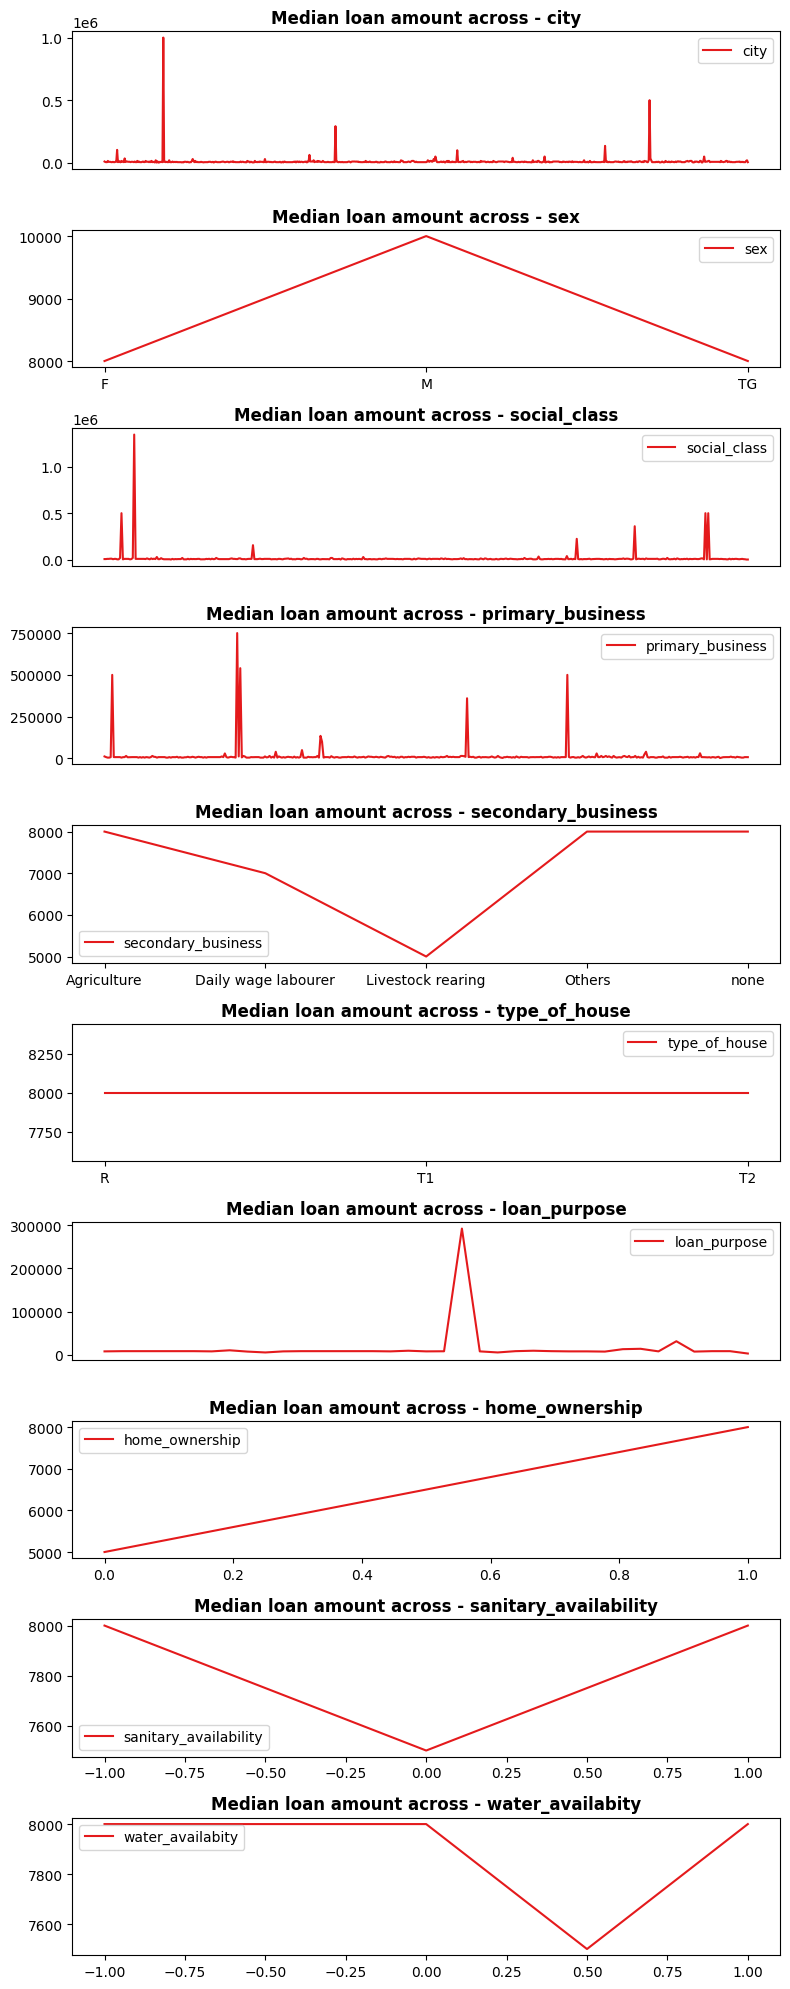

In [73]:
print('Variation of "median" loan_amount across each category in a categorical feature: \n')
fig, axis = plt.subplots(10,1, figsize=(8,20))

all_cols = list(median_loan_amts.keys())
for i, ax in enumerate(axis.flatten()):
    if i < len(median_loan_amts.keys()):
        median_price_df = pd.DataFrame.from_dict(median_loan_amts[all_cols[i]], orient='index', columns=[all_cols[i]])
        sns.lineplot(data=median_price_df, ax=ax, palette='Set1')
        ax.set_title('Median loan amount across - ' + all_cols[i], fontsize=12, fontweight='bold')
        max_value, min_value = round(max(median_price_df[all_cols[i]]), 0), round(min(median_price_df[all_cols[i]]), 0)

        # Check number of xticks
        if len(median_price_df.index) > 10:
            ax.set_xticks([])  # Remove xticks if count of all xticks>10

        diff = max_value - min_value
        print(f"\t For {all_cols[i]} - Max Value: {max_value} | Min Value: {min_value} | Difference = {diff}")
plt.tight_layout()
plt.show()

##### Numerical features:

In [74]:
len(num_features)

9

In [75]:
discreate_num_features, continuous_num_features = [], []

for feature in num_features:
        discreate_num_features.append(feature) if df[feature].nunique() <= 25 else continuous_num_features.append(feature)


In [76]:
discreate_num_features

['old_dependents',
 'young_dependents',
 'occupants_count',
 'loan_tenure',
 'loan_installments']

In [77]:
continuous_num_features

['age', 'annual_income', 'monthly_expenses', 'house_area']

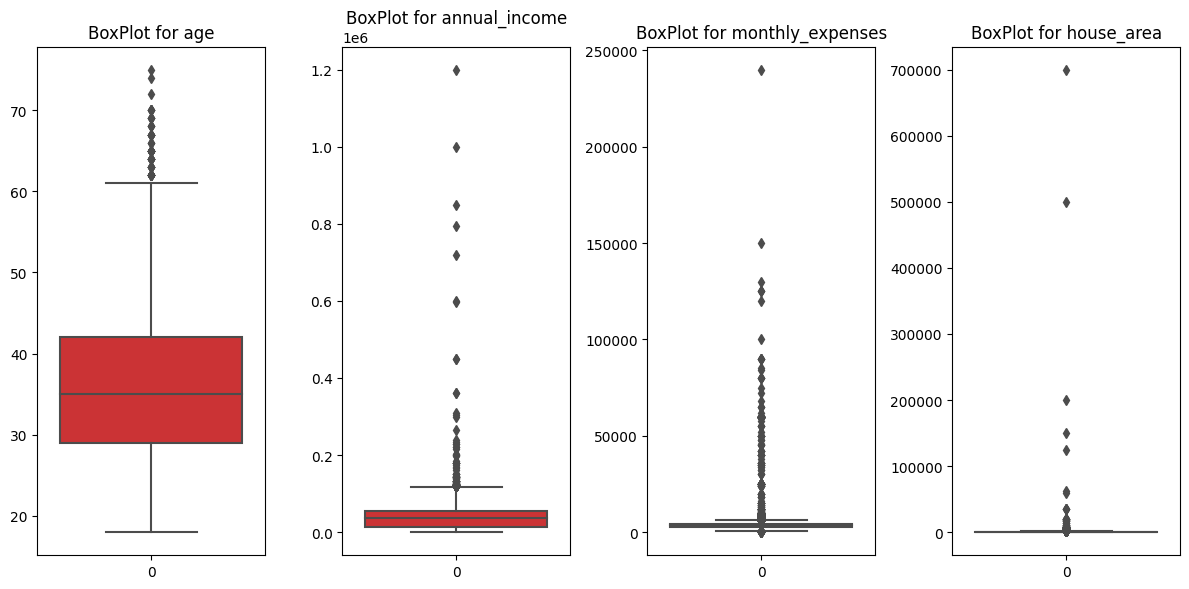

In [78]:
# Continuous Numerical Variable - Checking Outliers

fig, axis = plt.subplots(1,4, figsize=(12,6))
for i, ax in enumerate(axis.flatten()):
    if i < len(continuous_num_features):
        sns.boxplot(df[continuous_num_features[i]], ax=ax, palette='Set1')
        ax.set_title(f'BoxPlot for {continuous_num_features[i]}')
plt.tight_layout()
plt.show()

In [79]:
def drop_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_filtered

In [80]:
len(df)

39993

In [81]:
for feature in continuous_num_features:
    df = drop_outliers(df, feature)

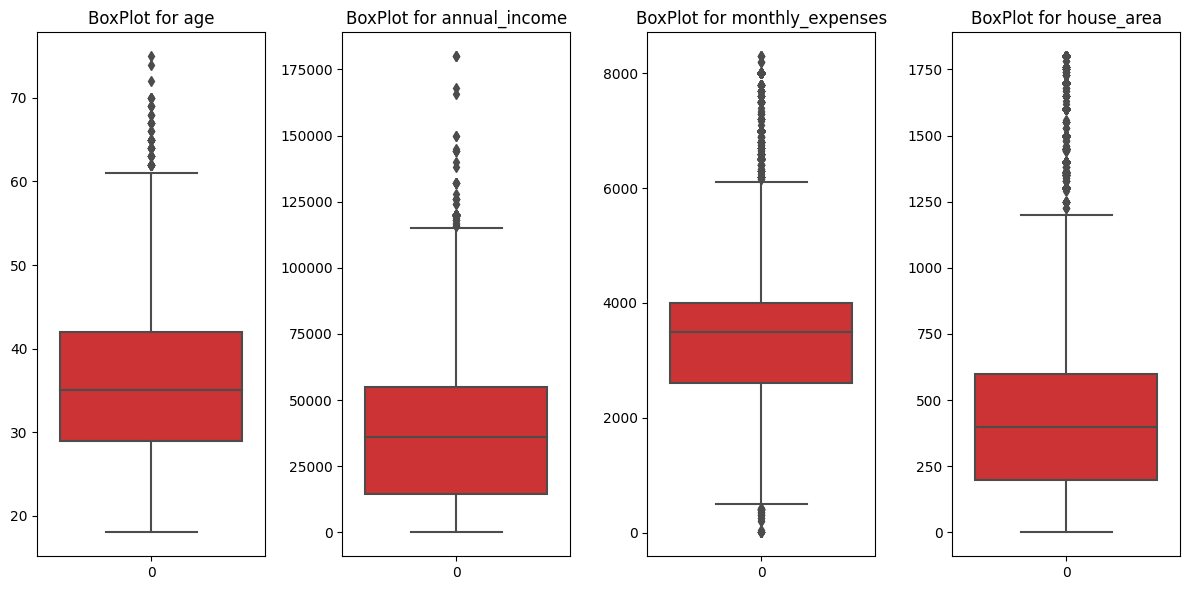

In [82]:
# Continuous Numerical Variable - Checking Outliers

fig, axis = plt.subplots(1,4, figsize=(12,6))
for i, ax in enumerate(axis.flatten()):
    if i < len(continuous_num_features):
        sns.boxplot(df[continuous_num_features[i]], ax=ax, palette='Set1')
        ax.set_title(f'BoxPlot for {continuous_num_features[i]}')
plt.tight_layout()
plt.show()

Looks better now!

In [83]:
len(df)

38661

In [84]:
import scipy.stats as stat
import pylab

In [85]:
def plot_data(df, feature):
    plt.figure(figsize = (10,4))

    plt.subplot(1,2,1)
    sns.histplot(df[feature], bins=50, kde=True, palette='Set1')
    plt.title(f'Histogram of feature - {feature}')

    plt.subplot(1,2,2)
    stat.probplot(df[feature], dist='norm', plot=pylab)

    plt.tight_layout()
    plt.show()

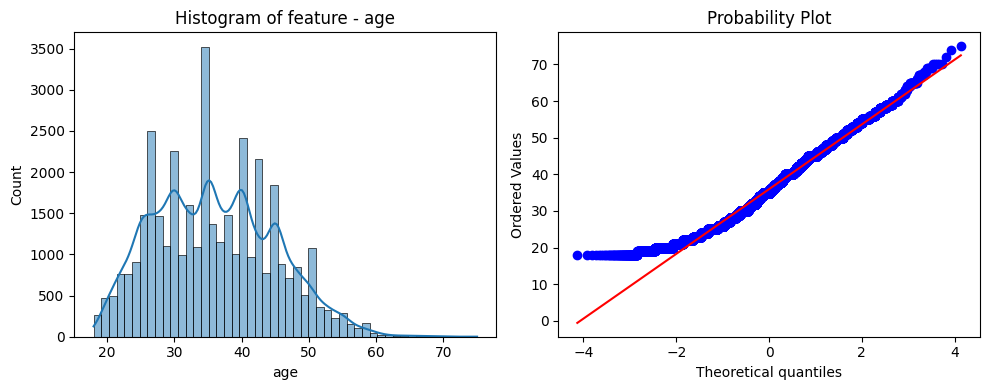

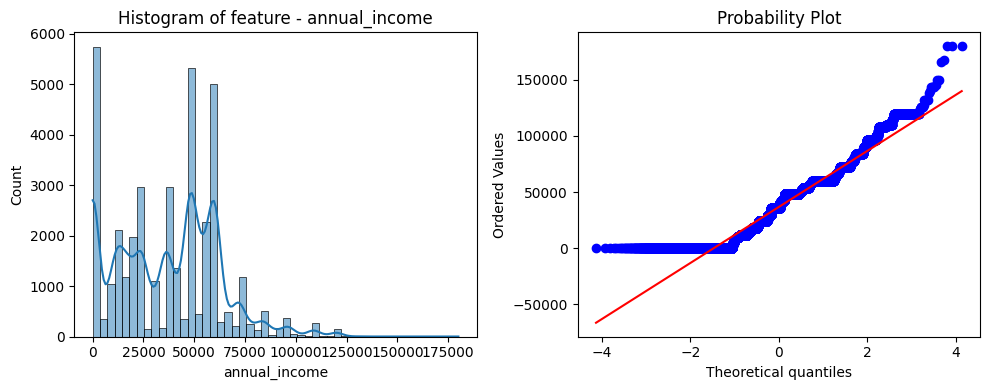

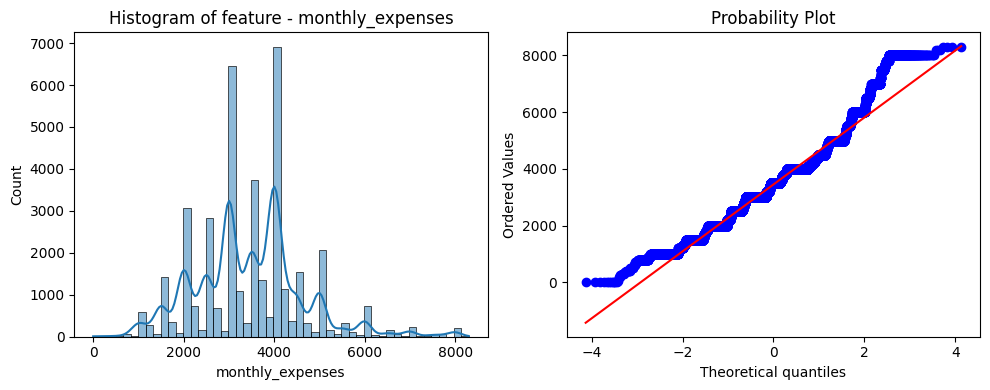

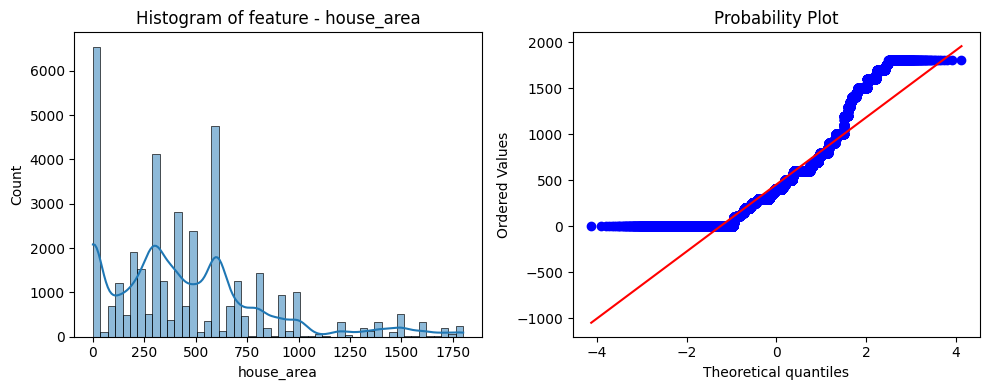

In [86]:
# Continuous Numerical Variables - Checking Normality

skipped_features = []
for feature in continuous_num_features:
    plot_data(df, feature=feature)

Let's try some transformations on **continuous numerical variables** to see if they can be further normalized

In [87]:
try_normalization = df.copy()[continuous_num_features]

In [88]:
try_normalization.head()

,age,annual_income,monthly_expenses,house_area
0,22,36000.0,5000.0,70.0
1,21,94000.0,3600.0,80.0
2,24,48000.0,4000.0,50.0
3,26,7000.0,5000.0,50.0
4,23,36000.0,3500.0,112.0


In [89]:
tansformations_to_apply = ['log', 'reciprocal', 'square_root', 'exponential', 'boxcox']

In [90]:
from scipy.stats import boxcox, yeojohnson


In [91]:
for feature in try_normalization.columns:
    for tr in tansformations_to_apply:
        if tr == 'log':
            try_normalization[feature + '_' + tr] = np.log(try_normalization[feature])
        elif tr == 'reciprocal':
            try_normalization[feature + '_' + tr] = 1 / try_normalization[feature].replace(0, np.nan)
        elif tr == 'square_root':
            try_normalization[feature + '_' + tr] = np.sqrt(try_normalization[feature])
        elif tr == 'exponential':
            try_normalization[feature + '_' + tr] = (try_normalization[feature])**(1/1.2)
        elif tr == 'boxcox':
            # Apply Box-Cox transformation, avoiding negative values if possible
            try:
                transformed_data, _ = boxcox(try_normalization[feature])
                try_normalization[feature + '_' + tr] = transformed_data
            except ValueError:
                # If Box-Cox fails, try Yeo-Johnson transformation
                print('BoxCox failed for:', feature, 'applying Yeo-Johnson instead!')
                transformed_data, _ = yeojohnson(try_normalization[feature])
                try_normalization[feature + '_' + tr] = transformed_data

BoxCox failed for: annual_income applying Yeo-Johnson instead!
BoxCox failed for: house_area applying Yeo-Johnson instead!


In [92]:
try_normalization.head()

,age,annual_income,monthly_expenses,house_area,age_log,age_reciprocal,age_square_root,age_exponential,age_boxcox,annual_income_log,annual_income_reciprocal,annual_income_square_root,annual_income_exponential,annual_income_boxcox,monthly_expenses_log,monthly_expenses_reciprocal,monthly_expenses_square_root,monthly_expenses_exponential,monthly_expenses_boxcox,house_area_log,house_area_reciprocal,house_area_square_root,house_area_exponential,house_area_boxcox
0,22,36000.0,5000.0,70.0,3.091042,0.045455,4.690416,13.142729,5.840015,10.491274,0.000028,189.736660,6264.966465,185.482163,8.517193,0.000200,70.710678,1209.135588,323.603577,4.248495,0.014286,8.366600,34.481147,12.511887
1,21,94000.0,3600.0,80.0,3.044522,0.047619,4.582576,12.642979,5.692717,11.451050,0.000011,306.594194,13940.335030,277.497707,8.188689,0.000278,60.000000,919.571319,263.352749,4.382027,0.012500,8.944272,38.539699,13.392180
2,24,48000.0,4000.0,50.0,3.178054,0.041667,4.898979,14.131102,6.122530,10.778956,0.000021,219.089023,7962.223507,209.326102,8.294050,0.000250,63.245553,1003.960577,281.349580,3.912023,0.020000,7.071068,26.050037,10.513421
3,26,7000.0,5000.0,50.0,3.258097,0.038462,5.099020,15.105825,6.390701,8.853665,0.000143,83.666003,1600.473054,92.774303,8.517193,0.000200,70.710678,1209.135588,323.603577,3.912023,0.020000,7.071068,26.050037,10.513421
4,23,36000.0,3500.0,112.0,3.135494,0.043478,4.795832,13.638707,5.983191,10.491274,0.000028,189.736660,6264.966465,185.482163,8.160518,0.000286,59.160798,898.235131,258.737869,4.718499,0.008929,10.583005,51.013096,15.856940


In [93]:
len(continuous_num_features), len(tansformations_to_apply)+1

(4, 6)

Normality of continuous_num_features after applying various transformations: 



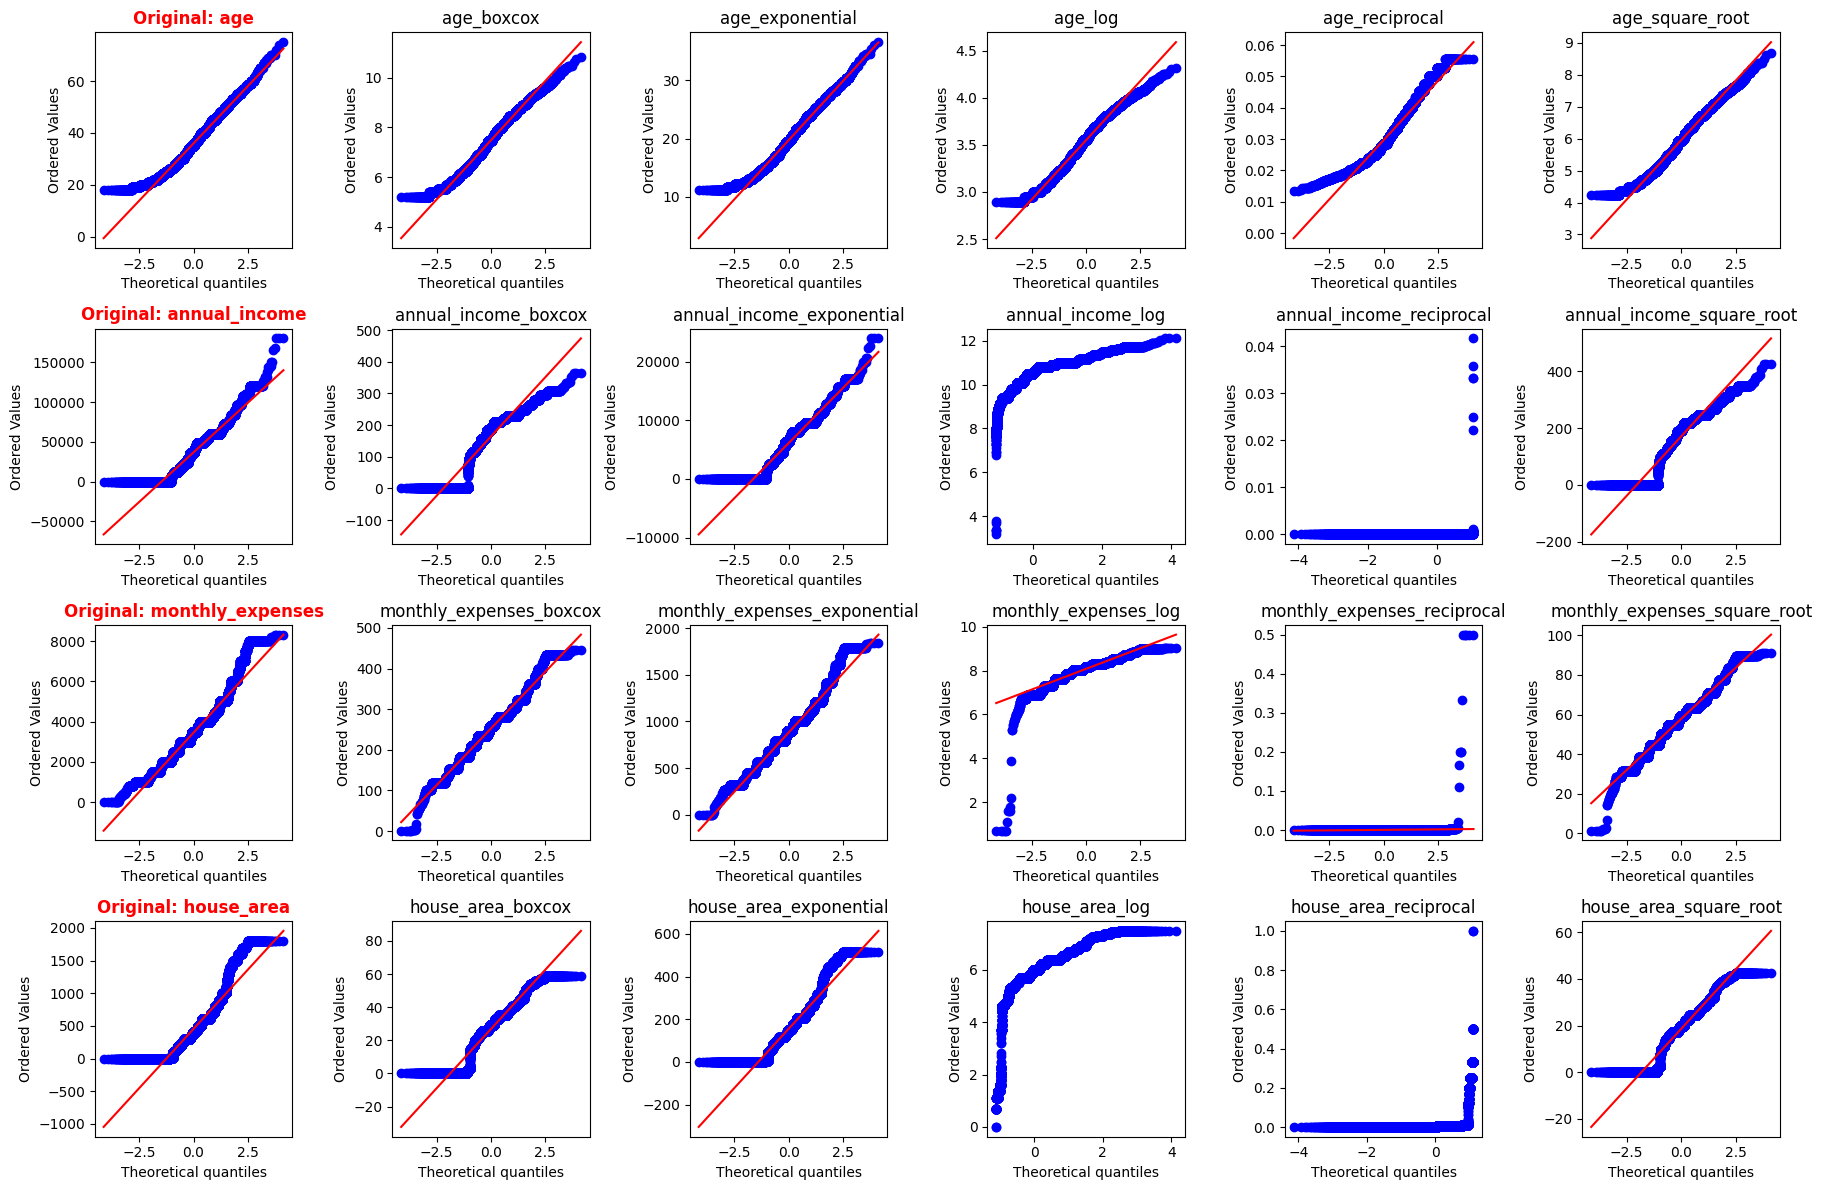

In [94]:
print('Normality of continuous_num_features after applying various transformations: \n')
fig, axis = plt.subplots(4, 6, figsize=(18, 12))

for i, feature in enumerate(continuous_num_features):
    for j, ax in enumerate(axis[i]):
        transformed_feature = sorted([col for col in try_normalization.columns if feature in col])
        if j < len(transformed_feature):
            stat.probplot(try_normalization[transformed_feature[j]], dist='norm', plot=ax)
            ax.set_title(f'Original: {feature}', fontsize=12, fontweight='bold', color='red') if transformed_feature[j] == feature else ax.set_title(transformed_feature[j])
plt.tight_layout()
plt.show()

**original** works best in almost all the **continuous_num_features**. Let's use as-is values.

#### Dataset preparation:

Skipping some features for model creation du the following reasons:
1. Either the feature has too many categorical features. They're - ['city', 'social_class', 'primary_business', 'secondary_business', 'loan_purpose']
2. The feature is not a good predictor for lending model. They're - ['sanitary_availability', 'water_availabity']

In [95]:
selected_features = [
    "Id", "age", "sex", "annual_income", "monthly_expenses", "old_dependents", "young_dependents",  "home_ownership", "type_of_house",
    "occupants_count", "house_area", "loan_tenure", "loan_installments"
]

In [96]:
print('Count of selected_features:', len(selected_features))

Count of selected_features: 13


In [97]:
dropped_features = [feat for feat in all_cols if feat not in selected_features]

print('All dropped features:', dropped_features)
print('Count:', len(dropped_features))

All dropped features: ['city', 'social_class', 'primary_business', 'secondary_business', 'loan_purpose', 'sanitary_availability', 'water_availabity']
Count: 7


In [98]:
selected_num_features = [feature for feature in num_features if feature in selected_features]

print('Selected num_features: \n', selected_num_features)
print('Count:', len(selected_num_features))

Selected num_features: 
 ['age', 'annual_income', 'monthly_expenses', 'old_dependents', 'young_dependents', 'occupants_count', 'house_area', 'loan_tenure', 'loan_installments']
Count: 9


In [99]:
selected_cat_features = [feature for feature in cat_features if feature in selected_features]

print('Selected cat_features:', selected_cat_features)
print('Count:', len(selected_cat_features))

Selected cat_features: ['sex', 'type_of_house', 'home_ownership']
Count: 3


In [100]:
df_selected_features = df[selected_features]

In [101]:
df_selected_features.head()

,Id,age,sex,annual_income,monthly_expenses,old_dependents,young_dependents,home_ownership,type_of_house,occupants_count,house_area,loan_tenure,loan_installments
0,1,22,F,36000.0,5000.0,0,2,1.0,R,4,70.0,12,12
1,2,21,F,94000.0,3600.0,1,1,1.0,T1,4,80.0,12,50
2,3,24,M,48000.0,4000.0,0,2,1.0,T1,4,50.0,12,12
3,4,26,F,7000.0,5000.0,0,2,1.0,T1,5,50.0,12,50
4,5,23,F,36000.0,3500.0,0,0,1.0,T1,1,112.0,12,12


In [102]:
X, y = df_selected_features.drop('Id', axis=1), df['loan_amount']

In [103]:
X.head()

,age,sex,annual_income,monthly_expenses,old_dependents,young_dependents,home_ownership,type_of_house,occupants_count,house_area,loan_tenure,loan_installments
0,22,F,36000.0,5000.0,0,2,1.0,R,4,70.0,12,12
1,21,F,94000.0,3600.0,1,1,1.0,T1,4,80.0,12,50
2,24,M,48000.0,4000.0,0,2,1.0,T1,4,50.0,12,12
3,26,F,7000.0,5000.0,0,2,1.0,T1,5,50.0,12,50
4,23,F,36000.0,3500.0,0,0,1.0,T1,1,112.0,12,12


In [104]:
y.head()

0    5000.0
1    7500.0
2    5000.0
3    7500.0
4    5000.0
Name: loan_amount, dtype: float64

Let's do a train_test_split before applying any scaling to avoid data leakage

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [107]:
X_train.head()

,age,sex,annual_income,monthly_expenses,old_dependents,young_dependents,home_ownership,type_of_house,occupants_count,house_area,loan_tenure,loan_installments
3602,47,F,12000.0,3600.0,0,0,1.0,T2,3,350.0,12,12
6897,20,F,12000.0,3000.0,0,1,1.0,T2,3,320.0,12,12
20431,43,F,14400.0,5000.0,0,0,1.0,R,4,700.0,12,50
8859,40,F,0.0,5200.0,0,0,1.0,T1,0,0.0,12,50
38758,34,F,60000.0,3000.0,0,0,1.0,R,2,600.0,12,12


In [108]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer

In [109]:
num_transformer = RobustScaler()
cat_transformer = OneHotEncoder(drop='first')

In [110]:
preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", cat_transformer, selected_cat_features),
        ("RobustScaler", num_transformer, selected_num_features),
    ]
)

In [111]:
X_train = preprocessor.fit_transform(X_train)

In [112]:
X_train.shape

(25902, 14)

In [113]:
column_names = preprocessor.get_feature_names_out()
len(column_names)

14

In [114]:
train_data = pd.DataFrame(X_train, columns=column_names)
train_data.head()

,OneHotEncoder__sex_M,OneHotEncoder__sex_TG,OneHotEncoder__type_of_house_T1,OneHotEncoder__type_of_house_T2,OneHotEncoder__home_ownership_1.0,RobustScaler__age,RobustScaler__annual_income,RobustScaler__monthly_expenses,RobustScaler__old_dependents,RobustScaler__young_dependents,RobustScaler__occupants_count,RobustScaler__house_area,RobustScaler__loan_tenure,RobustScaler__loan_installments
0,0.0,0.0,0.0,1.0,1.0,0.923077,-0.591133,0.071429,0.0,-0.5,0.0,-0.125,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,-1.153846,-0.591133,-0.357143,0.0,0.0,0.0,-0.200,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.615385,-0.532020,1.071429,0.0,-0.5,0.5,0.750,0.0,1.0
3,0.0,0.0,1.0,0.0,1.0,0.384615,-0.886700,1.214286,0.0,-0.5,-1.5,-1.000,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,-0.076923,0.591133,-0.357143,0.0,-0.5,-0.5,0.500,0.0,0.0


In [115]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25902 entries, 0 to 25901
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   OneHotEncoder__sex_M               25902 non-null  float64
 1   OneHotEncoder__sex_TG              25902 non-null  float64
 2   OneHotEncoder__type_of_house_T1    25902 non-null  float64
 3   OneHotEncoder__type_of_house_T2    25902 non-null  float64
 4   OneHotEncoder__home_ownership_1.0  25902 non-null  float64
 5   RobustScaler__age                  25902 non-null  float64
 6   RobustScaler__annual_income        25902 non-null  float64
 7   RobustScaler__monthly_expenses     25902 non-null  float64
 8   RobustScaler__old_dependents       25902 non-null  float64
 9   RobustScaler__young_dependents     25902 non-null  float64
 10  RobustScaler__occupants_count      25902 non-null  float64
 11  RobustScaler__house_area           25902 non-null  flo

Let's check feature importance of train_data:

In [116]:
from sklearn.ensemble import ExtraTreesRegressor

In [117]:
extra_trees = ExtraTreesRegressor(n_estimators=100, random_state=42)

In [118]:
extra_trees.fit(train_data, y_train)

ExtraTreesRegressor(random_state=42)

In [119]:
feat_importances = pd.Series(extra_trees.feature_importances_, index=train_data.columns).reset_index()
feat_importances = feat_importances.rename(columns={'index': 'feature', 0: 'importance'}).sort_values(by='importance')

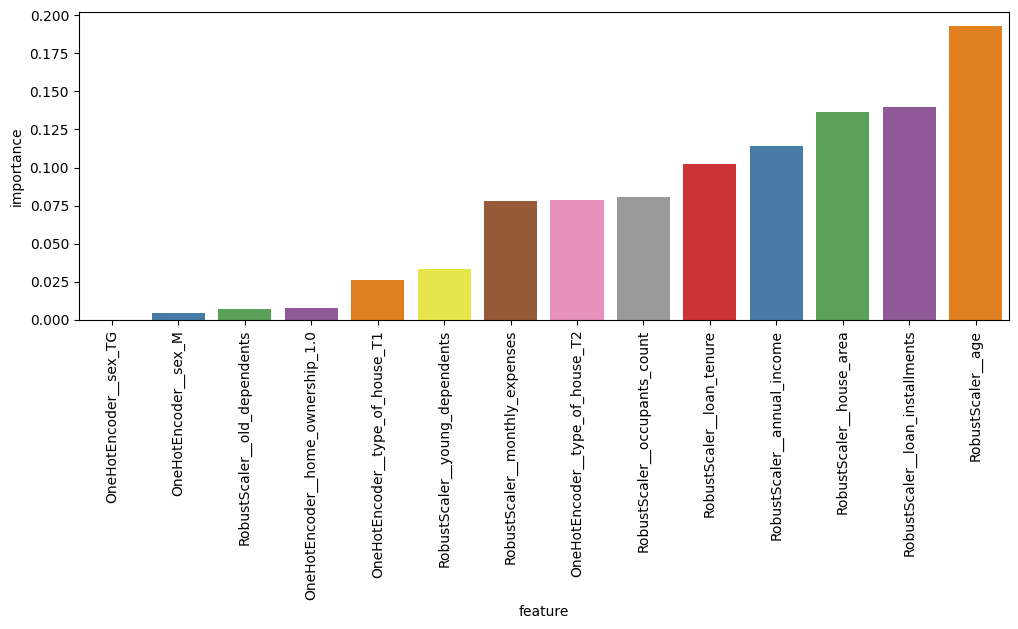

In [120]:
plt.figure(figsize=(12,4))
sns.barplot(data=feat_importances, x='feature', y='importance', palette='Set1')
plt.xticks(rotation=90)

plt.show()

In [121]:
X_test = preprocessor.transform(X_test)

In [122]:
test_data = pd.DataFrame(X_test, columns=column_names)
test_data.head()

,OneHotEncoder__sex_M,OneHotEncoder__sex_TG,OneHotEncoder__type_of_house_T1,OneHotEncoder__type_of_house_T2,OneHotEncoder__home_ownership_1.0,RobustScaler__age,RobustScaler__annual_income,RobustScaler__monthly_expenses,RobustScaler__old_dependents,RobustScaler__young_dependents,RobustScaler__occupants_count,RobustScaler__house_area,RobustScaler__loan_tenure,RobustScaler__loan_installments
0,0.0,0.0,1.0,0.0,1.0,1.692308,-0.886700,0.500000,0.0,-0.5,-1.5,-1.00,0.0,1.0
1,0.0,0.0,1.0,0.0,1.0,-0.846154,0.295567,0.357143,0.0,-0.5,-0.5,0.75,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,-1.076923,-0.591133,0.214286,0.0,0.0,0.0,0.50,0.0,1.0
3,0.0,0.0,1.0,0.0,1.0,-0.769231,-0.295567,0.357143,0.0,0.5,0.5,1.25,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,-0.230769,-0.532020,0.142857,0.0,0.0,0.0,-0.25,0.0,1.0


#### Training

In [123]:
# Modelling
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
# from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [124]:
def evaluate_model(true, predicted):
    mae = round(mean_absolute_error(true, predicted), 3)
    mape = round(mean_absolute_percentage_error(true, predicted), 3)
    mse = round(mean_squared_error(true, predicted), 3)
    rmse = round(np.sqrt(mean_squared_error(true, predicted)), 3)
    return mae, mape, mse, rmse

In [125]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "AdaBoost Regressor": AdaBoostRegressor(),
    "XGBoost Regressor": XGBRegressor(),
    # "CatBoost Regressor": CatBoostRegressor(verbose=False),
}

In [126]:
full_report = {}

for model_name in models:
    model_report = {}

    model = models[model_name]
    model.fit(train_data, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(train_data)
    y_test_pred = model.predict(test_data)

    model_report['predictions'] = y_test_pred

    # Evaluate Train and Test dataset
    model_train_mae, model_train_mape, model_train_mse, model_train_rmse = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_mape, model_test_mse, model_test_rmse = evaluate_model(y_test, y_test_pred)

    model_report['train_mae'] = model_train_mae
    model_report['train_mape'] = model_train_mape
    model_report['train_mse'] = model_train_mse
    model_report['train_rmse'] = model_train_rmse

    model_report['test_mae'] = model_test_mae
    model_report['test_mape'] = model_test_mape
    model_report['test_mse'] = model_test_mse
    model_report['test_rmse'] = model_test_rmse

    print('>>>', model_name)

    print('Model performance for Training set: ')
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- Mean Absolute Percentage Error: {:.4f}".format(model_train_mape))
    print("- Mean Squared Error: {:.4f}".format(model_train_mse))
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))

    print('----------------------------------')

    print('Model performance for Test set: ')
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- Mean Absolute Percentage Error: {:.4f}".format(model_test_mape))
    print("- Mean Squared Error: {:.4f}".format(model_test_mse))
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))

    print('\n')

    full_report[model_name] = model_report

>>> Linear Regression
Model performance for Training set: 
- Mean Absolute Error: 2655.3120
- Mean Absolute Percentage Error: 0.3410
- Mean Squared Error: 229871005.9140
- Root Mean Squared Error: 15161.4970
----------------------------------
Model performance for Test set: 
- Mean Absolute Error: 3203.7090
- Mean Absolute Percentage Error: 0.4360
- Mean Squared Error: 8827858482.4270
- Root Mean Squared Error: 93956.6840


>>> Ridge
Model performance for Training set: 
- Mean Absolute Error: 2655.2610
- Mean Absolute Percentage Error: 0.3410
- Mean Squared Error: 229871010.1420
- Root Mean Squared Error: 15161.4980
----------------------------------
Model performance for Test set: 
- Mean Absolute Error: 3203.6660
- Mean Absolute Percentage Error: 0.4360
- Mean Squared Error: 8828121928.2760
- Root Mean Squared Error: 93958.0860


>>> Lasso
Model performance for Training set: 
- Mean Absolute Error: 2654.3260
- Mean Absolute Percentage Error: 0.3400
- Mean Squared Error: 229871210.814

#### Analysis:

In [127]:
all_models = list(full_report.keys())
all_models

['Linear Regression',
 'Ridge',
 'Lasso',
 'K-Neighbors Regressor',
 'Decision Tree Regressor',
 'Random Forest Regressor',
 'AdaBoost Regressor',
 'XGBoost Regressor']

In [128]:
true_and_predicted = {
    'true': y_test.values
}

In [129]:
for model in all_models:
    true_and_predicted[model + '_prediction'] = full_report[model]['predictions']

In [130]:
model_analysis = pd.DataFrame(true_and_predicted)
model_analysis.head(20)

,true,Linear Regression_prediction,Ridge_prediction,Lasso_prediction,K-Neighbors Regressor_prediction,Decision Tree Regressor_prediction,Random Forest Regressor_prediction,AdaBoost Regressor_prediction,XGBoost Regressor_prediction
0,7500.0,7085.382000,7085.579586,7082.178900,6500.0,5000.0,6825.000000,8824.407115,6257.678711
1,10000.0,9206.337569,9206.166819,9205.417863,6000.0,5000.0,6290.000000,24982.180954,6385.441895
2,8000.0,7831.998346,7831.957477,7832.460404,9600.0,8000.0,8690.000000,9163.410209,8953.596680
3,14000.0,8437.441703,8437.440853,8438.318628,14000.0,13000.0,13246.666667,24982.180954,12851.458984
4,12000.0,7676.831224,7676.847092,7676.021085,8200.0,8000.0,9950.000000,9163.410209,9512.225586
5,10000.0,6900.636701,6900.928505,6905.498259,8800.0,10000.0,9260.500000,9163.410209,10592.639648
6,8000.0,10265.327320,10265.098586,10257.267867,12400.0,12000.0,11906.428571,9163.410209,12017.504883
7,5000.0,8728.409901,8727.766342,8713.442355,5000.0,5000.0,5590.000000,9163.410209,6887.712402
8,5000.0,6324.167124,6324.404639,6324.515245,5000.0,5000.0,5030.666667,8824.407115,4833.539551
9,8000.0,8256.525555,8256.562803,8255.050134,9100.0,7500.0,8745.000000,9163.410209,8607.190430


In [131]:
for model_prediction in model_analysis.columns[1:]:
    a_model = model_analysis[['true', model_prediction]]
    a_model['error_rate'] = 100*abs(a_model[model_prediction] - a_model['true'])/a_model['true']

    print(f"For {model_prediction}:")
    print(f" - mean true value = {round(a_model['true'].mean(), 2)}")
    print(f" - mean predicted value = {round(a_model[model_prediction].mean(), 2)}")
    print(f" - mean error rate = {round(a_model['error_rate'].mean(), 2)}")
    print(f" -> mean accuracy = {round(100 - a_model['error_rate'].mean(), 2)}")

    print('----------------------------------------')

    print(f" - median true value = {round(a_model['true'].median(), 2)}")
    print(f" - median predicted value = {round(a_model[model_prediction].median(), 2)}")
    print(f" - median error rate = {round(a_model['error_rate'].median(), 2)}")
    print(f" -> median accuracy = {round(100 - a_model['error_rate'].median(), 2)}")

    print('\n---------------------------------------------------------------')


For Linear Regression_prediction:
 - mean true value = 8172.4
 - mean predicted value = 9286.06
 - mean error rate = 43.63
 -> mean accuracy = 56.37
----------------------------------------
 - median true value = 8000.0
 - median predicted value = 8375.21
 - median error rate = 25.4
 -> median accuracy = 74.6

---------------------------------------------------------------
For Ridge_prediction:
 - mean true value = 8172.4
 - mean predicted value = 9286.1
 - mean error rate = 43.63
 -> mean accuracy = 56.37
----------------------------------------
 - median true value = 8000.0
 - median predicted value = 8375.72
 - median error rate = 25.41
 -> median accuracy = 74.59

---------------------------------------------------------------
For Lasso_prediction:
 - mean true value = 8172.4
 - mean predicted value = 9284.61
 - mean error rate = 43.6
 -> mean accuracy = 56.4
----------------------------------------
 - median true value = 8000.0
 - median predicted value = 8376.96
 - median error r

Looking at loss metrics and mean/median variation of difference b/w true & predicted across all models: **Random Forest Regressor** is the best one!

Let's do some **hyperparameter tuning** to obtain the best Randon Forest Regressor model:

In [131]:
from sklearn.model_selection import GridSearchCV

In [132]:
param_grid = {
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [None, 10],
    'max_features': [None, 'sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5],
    'n_estimators': [10, 100],
    'random_state': [42]
}

In [133]:
rf = RandomForestRegressor()

In [134]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_percentage_error', verbose=3)
grid_search.fit(train_data, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits

[CV 1/5] END criterion=squared_error, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10, random_state=42;, score=-0.128 total time=   0.2s

[CV 2/5] END criterion=squared_error, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10, random_state=42;, score=-0.127 total time=   0.1s

[CV 3/5] END criterion=squared_error, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10, random_state=42;, score=-0.129 total time=   0.1s

[CV 4/5] END criterion=squared_error, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10, random_state=42;, score=-0.130 total time=   0.1s

[CV 5/5] END criterion=squared_error, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10, random_state=42;, score=-0.129 total time=   0.1s

[CV 1/5] END criterion=squa

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [None, 10],
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5], 'n_estimators': [10, 100],
                         'random_state': [42]},
             scoring='neg_mean_absolute_percentage_error', verbose=3)

In [135]:
# Best parameters
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'criterion': 'absolute_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10, 'random_state': 42}


In [136]:
best_estimator = grid_search.best_estimator_

In [137]:
best_estimator_preds_train_data = best_estimator.predict(train_data)
best_estimator_preds_test_data = best_estimator.predict(test_data)

In [138]:
# Evaluate Train and Test dataset
model_train_mae, model_train_mape, model_train_mse, model_train_rmse = evaluate_model(y_train, best_estimator_preds_train_data)
model_test_mae, model_test_mape, model_test_mse, model_test_rmse = evaluate_model(y_test, best_estimator_preds_test_data)

In [139]:
print('Best Estimator performance for Training set: ')
print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
print("- Mean Absolute Percentage Error: {:.4f}".format(model_train_mape))
print("- Mean Squared Error: {:.4f}".format(model_train_mse))
print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))

print('----------------------------------')

print('Best Estimator performance for Test set: ')
print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
print("- Mean Absolute Percentage Error: {:.4f}".format(model_test_mape))
print("- Mean Squared Error: {:.4f}".format(model_test_mse))
print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))

Best Estimator performance for Training set: 

- Mean Absolute Error: 754.1680

- Mean Absolute Percentage Error: 0.1220

- Mean Squared Error: 2336573.7760

- Root Mean Squared Error: 1528.5860

----------------------------------

Best Estimator performance for Test set: 

- Mean Absolute Error: 768.3270

- Mean Absolute Percentage Error: 0.1250

- Mean Squared Error: 2269981.5160

- Root Mean Squared Error: 1506.6460
